In [1]:
from DataParser import get_df_list

# df's containing only the signals captured when the machine is touching
df_list = get_df_list()

## Data Visualization

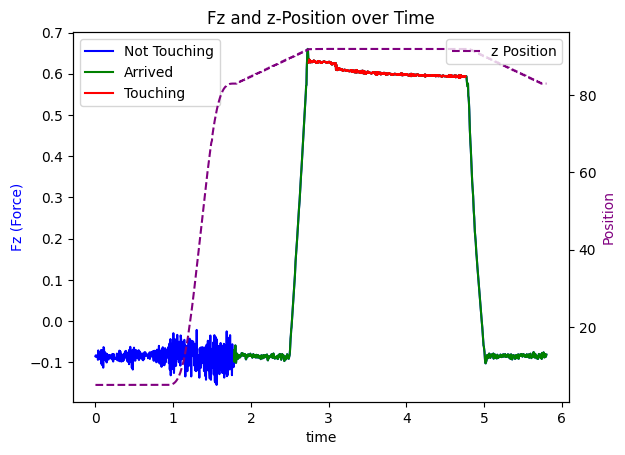

In [2]:
from DataParser import clean_df
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Dataset/20250205_082609_HIST_006_CPXE_1.csv')
df = clean_df(df)

touching_rows = df[df['isTouching_SMAC'] == 1]
arrived_rows = df[df['isArrived_Festo'] == 1]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

df.plot(x='t', y='Fz', color='blue', label='Not Touching', ax=ax1)
arrived_rows.plot(x='t', y='Fz', color='green', label='Arrived', ax=ax1)
touching_rows.plot(x='t', y='Fz', color='red', label='Touching', ax=ax1)
df.plot(x='t', y='posz', color='purple', linestyle='dashed', label='z Position', ax=ax2)

# Labels and legends
ax1.set_xlabel('time')
ax1.set_ylabel('Fz (Force)', color='blue')
ax2.set_ylabel('Position', color='purple')

# Adjust legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Fz and z-Position over Time')
plt.show()


## Energy calculation + Signals have different support

In [3]:
sorted_dfs = sorted(df_list, key=len, reverse=True)
print(", ".join(str(len(df)) for df in sorted_dfs[:100]))  # print number of points in the longest 100 signals

1858, 1035, 1022, 1021, 1021, 1020, 1020, 1019, 1019, 1017, 1016, 1015, 1015, 1015, 1014, 1014, 1013, 1013, 1012, 1012, 1012, 1011, 1011, 1011, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1009, 1009, 1009, 1009, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1004


In [4]:
import numpy as np

df_max_energy = (0, None)  # (energy, df_max_energy)


def calculate_energy(df):
    global df_max_energy
    energy = np.sum(df['Fz'] ** 2)

    if energy > df_max_energy[0]:
        df_max_energy = (energy, df)

    x = df['posx'].iloc[0]
    y = df['posy'].iloc[0]
    return x, y, energy


# Calculate energy for each df
energies = []
for df in df_list:
    result = calculate_energy(df)
    energies.append(result)

# Convert to numpy array
energies = np.array(energies)
print(energies.shape)
print(energies[:, 0].min(), energies[:, 0].max())  # x bounds
print(energies[:, 1].min(), energies[:, 1].max())  # y bounds 
print(energies[:, 2].min(), energies[:, 2].max())  # energy bounds 

(6561, 3)
59.999 140.0
59.999 140.0
134.75135042768773 412.1968582307687


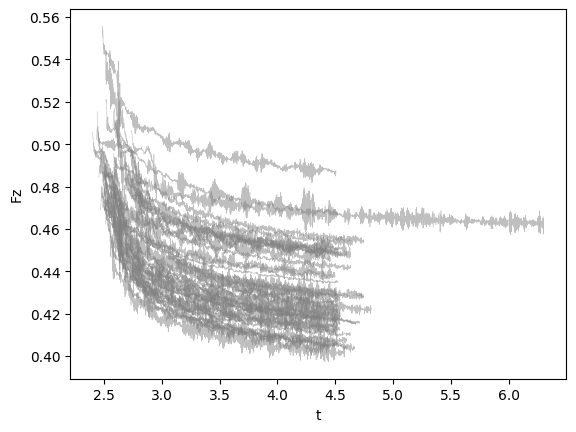

In [5]:
import random
import matplotlib.pyplot as plt

# Randomly select 40 DataFrames from df_list and add the max Energy df
sampled_dfs = random.sample(df_list, 40)
sampled_dfs.append(df_max_energy[1])

fig, ax = plt.subplots()

for df in sampled_dfs:
    df.plot(x='t', y='Fz',
            color='gray',  # Set color to gray
            alpha=0.5,  # Add some transparency
            linewidth=0.4,  # Very thin lines
            legend=False,  # Don't show legend for each line
            ax=ax)  # Use the same axis

plt.xlabel('t')
plt.ylabel('Fz')
plt.show()

## Plot points location in the plane

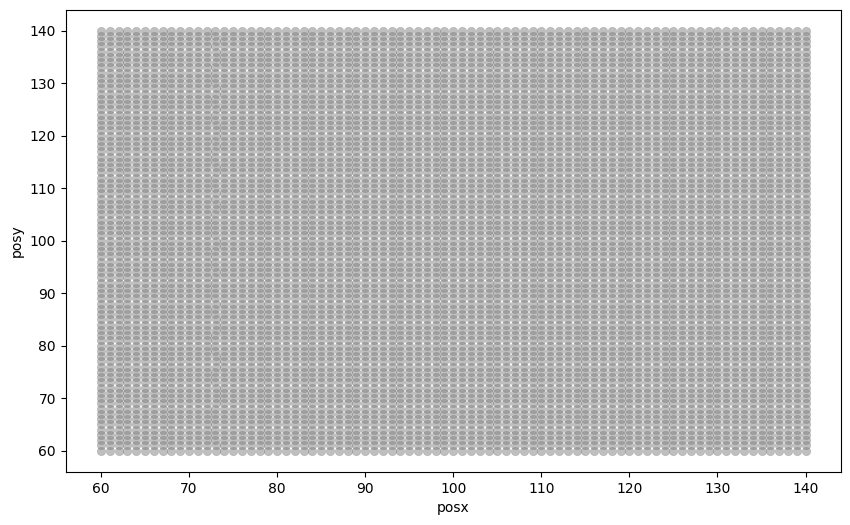

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each CSV file
for df in df_list:
    first_row = df.iloc[0]  # Get the first row, assuming x-y doesn't change over the acquisition
    ax.scatter(first_row['posx'], first_row['posy'],
               color='gray', alpha=0.5, linewidth=0.4)

# Labels and show plot
plt.xlabel('posx')
plt.ylabel('posy')
plt.show()

## Energies calculations and Plot

In [7]:
unique_sorted_values = np.sort(np.unique(energies[:, 2]))

# Get the top 30 largest values
print(unique_sorted_values[-30:])

[264.86032994 265.05357521 265.38232044 265.60567416 265.9656706
 268.40513251 271.85218498 272.0905447  274.0498576  274.38633186
 274.91552526 277.89300671 278.00355433 278.68539207 279.38627072
 280.07213836 282.66986764 283.54872635 284.00139194 290.72323952
 293.99160414 297.38182932 301.49019216 304.73835524 323.05901098
 327.57389857 330.17951306 334.65206686 366.92606431 412.19685823]


In [8]:
%matplotlib notebook 

xmin, xmax = 55, 145
ymin, ymax = 55, 145
emin, emax = 120, 400

filtered_energies = np.array(list(
    filter(lambda energy: xmin < energy[0] < xmax and ymin < energy[1] < ymax and emin < energy[2] < emax,
           energies)))  # select x-y-energy range to plot

z_scale_factor = 30  # Increase this to stretch z visually
min_energy = filtered_energies[:, 2].min()
max_energy = filtered_energies[:, 2].max()
filtered_energies[:, 2] = (filtered_energies[:, 2] - min_energy) / (max_energy - min_energy) * z_scale_factor

# Create interactive 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

zmin, zmax = filtered_energies[:, 2].min(), filtered_energies[:, 2].max()
ax.set_box_aspect([xmax - xmin, ymax - ymin, zmax - zmin])  # Keeps X and Y scales equal

trisurf = ax.plot_trisurf(filtered_energies[:, 0], filtered_energies[:, 1], filtered_energies[:, 2],
                          cmap='viridis',
                          edgecolor='none',  # Removes grid lines for a smoother surface look
                          alpha=0.8)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Normalized Energy Scaled')

fig.colorbar(trisurf, label='Normalized Energy Scaled')
plt.title('Signal Energy Distribution (Interactive)')

plt.show()


<IPython.core.display.Javascript object>